<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###univariate time series LSTM first try

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

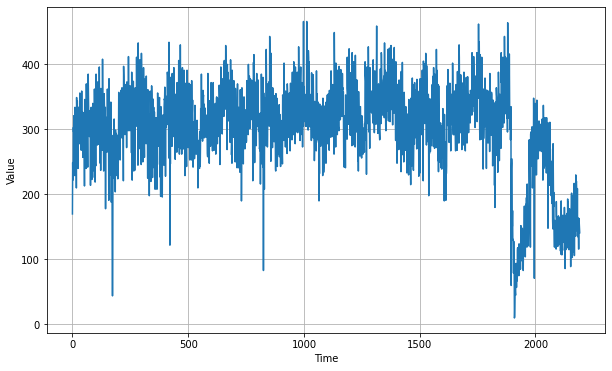

In [17]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
#df = df.iloc[:1850]

series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

Clean data by removing the three pics from the series

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))


split_time = 2000  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 7 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 30

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (2192, 1)
train (2000, 1)
test (192, 1)


In [19]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [45]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 128
shuffle_buffer = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.SimpleRNN(256, return_sequences=True),
  #tf.keras.layers.SimpleRNN(32, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (2000, 1)
Epoch 1/20
16/16 [==============================] - 4s 36ms/step - loss: 0.4099 - mae: 0.7353
Epoch 2/20
16/16 [==============================] - 1s 36ms/step - loss: 0.2010 - mae: 0.4780
Epoch 3/20
16/16 [==============================] - 1s 37ms/step - loss: 0.1148 - mae: 0.3442
Epoch 4/20
16/16 [==============================] - 1s 38ms/step - loss: 0.0685 - mae: 0.2669
Epoch 5/20
16/16 [==============================] - 1s 37ms/step - loss: 0.0427 - mae: 0.2155
Epoch 6/20
16/16 [==============================] - 1s 38ms/step - loss: 0.0301 - mae: 0.1827
Epoch 7/20
16/16 [==============================] - 1s 37ms/step - loss: 0.0236 - mae: 0.1649
Epoch 8/20
16/16 [==============================] - 1s 37ms/step - loss: 0.0195 - mae: 0.1516
Epoch 9/20
16/16 [==============================] - 1s 37ms/step - loss: 0.0172 - mae: 0.1422
Epoch 10/20
16

In [46]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",scaler.inverse_transform(np.squeeze(rnn_forecast)))
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[271.91687 258.75705 219.52856 ... 243.81549 267.11902 297.14426]
 [283.73416 261.96887 244.58246 ... 281.99277 331.27692 289.00406]
 [277.1038  256.9003  269.40796 ... 327.63785 304.2684  302.2842 ]
 ...
 [272.06058 234.75769 178.96512 ... 174.52754 186.86359 181.69269]
 [272.47098 235.60445 170.24944 ... 140.5335  181.30185 161.27087]
 [272.374   228.71448 174.15503 ... 151.96918 163.96474 151.69022]]
(2186, 7, 1)

2 [192]


In [47]:
#results['Date'] = df['Date']
pred = pd.DataFrame(scaler.inverse_transform(rnn_forecast.reshape(-1,1)))
real = pd.DataFrame(scaler.inverse_transform(x_valid))

results = pd.concat([real,pred, real-pred], axis = 1)
#results = results.rename(columns={0: ('flux_réel', 'prediction')})
print('Max = ', max(results.iloc[:,2]))
print([int(i) for i in list(results.iloc[:,2])])

Max =  32.6707763671875
[-11, 9, -33, -32, -65, -57, 32, -11, -14, -47, 8, -34, -46, -8, 6, 22, 0, 15, -18, -37, 12, -7, 8, -9, -16, 6, -32, 15, -7, 24, -3, -22, -72, -77, 32, 0, -71, -63, -47, -40, -70, -7, -9, 25, -28, -7, -38, -69, 12, -20, -32, -37, 6, -49, -158, -3, -57, -7, -109, -46, -89, -95, -7, -63, -24, -63, -53, -82, -119, -73, -56, -74, -104, -67, -129, -141, -27, -56, -83, -56, -96, -98, -175, -134, -77, -30, -63, -31, -10, -58, 10, -18, -7, -22, -23, -30, -63, -22, -25, -12, -37, -14, -48, -41, -26, -51, -14, -23, -37, -32, -38, 26, -48, -12, -67, 11, -48, -41, 0, 16, 2, 8, 1, -46, -41, 6, -32, -15, -95, -2, -19, -63, -20, 12, -13, -8, -23, -2, -63, 19, -42, 15, -33, -10, -65, -65, -13, -2, -38, -15, -23, -15, -91, -18, 2, 15, -3, -2, -22, -64, 0, -45, -51, -56, 1, -13, -80, 28, -83, 0, -41, 20, 2, -51, 29, 10, 15, -27, -36, -85, -113, -71, -139, -82, -94, -33, -80, -66, -16, -18, -34, -20]


(192,)
(192, 1)
(192,)


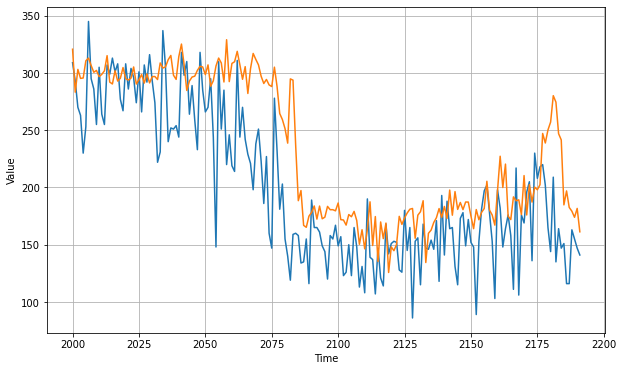

In [48]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, scaler.inverse_transform(x_valid)) # 2-D
plot_series(time_valid, scaler.inverse_transform(rnn_forecast.reshape(-1,1))) # we only took the last part of the rnn_forecast


In [49]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # CNN LSTM 1.77

array([0.16724133, 0.1456304 , 0.13618904, 0.13398658, 0.12803283,
       0.1312565 , 0.24391161, 0.14731468, 0.14188199, 0.13175906,
       0.16030292, 0.13428354, 0.13175906, 0.16361737, 0.15190144,
       0.17491914, 0.1545539 , 0.1654104 , 0.13848417, 0.1352296 ,
       0.1654104 , 0.14188199, 0.15879686, 0.14834607, 0.13746828,
       0.1545539 , 0.13490981, 0.16361737, 0.14493416, 0.1810237 ,
       0.1456304 , 0.13746828, 0.12760516, 0.12810136, 0.22636776,
       0.16030292, 0.12884218, 0.13100523, 0.13076235, 0.13150778,
       0.12944676, 0.18520267, 0.15064533, 0.16911893, 0.13428354,
       0.14323595, 0.13280644, 0.12823842, 0.18520267, 0.14144796,
       0.13490981, 0.13618904, 0.14731468, 0.12944676, 0.18932605,
       0.16911893, 0.13076235, 0.14144796, 0.12752317, 0.12976658,
       0.12750033, 0.12738611, 0.171023  , 0.12944676, 0.13618904,
       0.12912697, 0.1279643 , 0.12755947, 0.12777248, 0.12860383,
       0.13076235, 0.12765084, 0.1312169 , 0.12783359, 0.16554